After fine-tuning the model, the next step is to serve it in production. You may have heard of [vLLM](https://docs.vllm.ai/en/latest/), an open-source library built for fast and memory-efficient LLM serving. vLLM achieves high throughput and low latency through optimized key-value (K-V) caching and continuous batching. It supports popular Hugging Face models and offers a simple API for deployment. In this task, you'll explore how vLLM's PagedAttention mechanism enhances batch serving. After that, you'll explore the possibility of using speculative decoding to further improve the serving efficiency of your model.

# Step 0: Install vllm and try it out

In [ ]:
!pip install vllm
!pip uninstall transformers -y
!pip install transformers

--------------
**After reinstalling transformers, please restart the session before proceeding!!** For google colab, click Runtime (in the menu bar) -> Restart Session. After restarting session, you don't need to reexecute the above cell because you're still in the same virtual environment.

In [ ]:
import vllm

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from vllm import SamplingParams
model_id = "meta-llama/Llama-3.2-1B-Instruct"
# Explicitly set dtype to 'half' (float16) to avoid bfloat16 errors on Tesla gpu
llm = vllm.LLM(model=model_id, dtype="half")
prompts = [
    "Hello, my name is",
    "The president of the United States is",
    "The capital of France is",
    "The future of AI is",
]
# Create a sampling params object.
sampling_params = SamplingParams(temperature=0.8, top_p=0.95)
outputs = llm.generate(prompts, sampling_params)
# Print the outputs.
for output in outputs:
    prompt = output.prompt
    generated_text = output.outputs[0].text
    print(f"Prompt: {prompt!r}, Generated text: {generated_text!r}")

In [ ]:
# always remember to delete the llm object if you're not using it anymore to save gpu memory.
import gc
import torch
del llm
gc.collect()
torch.cuda.empty_cache()

# Step 2: Compare VLLM with Huggingface Transformers (20pt)

The [PagedAttention](https://arxiv.org/pdf/2309.06180) mechanism in vLLM reduces memory fragmentation, particularly when prompt and output lengths vary. This leads to a lower memory footprint and enables higher throughput. Since HuggingFace Transformers do not support continuous batching, direct throughput comparison is unfair. A more objective way to demonstrate the advantage of PagedAttention is by measuring peak memory usage under variable-length inputs and outputs.

**Your task:**

Design an experiment to compare the peak GPU memory usage of vLLM and HuggingFace Transformers when serving a batch of prompts with diverse prompt lengths. Analyze how memory usage scales as you increase the variance of prompt length, and explain how this relates to the benefits of PagedAttention. We use meta-llama/Llama-3.2-1B-Instruct model to do the experiment.

Requirement
1. For simplicity, control the output length to always be 1. Set the input lengths' standard deviation to be: [1,20,40,60,80,100]
2. Use the generate_batch_with_gaussian_lengths() function below to generate input batches of different length variance. By default, you should keep mean=200, batch_size=64, vocab="word". It should run well on Google Colab T4 GPU if you manage the memory wisely (e.g., delete models that has finished running in time, etc.).
3. The final result of your experiment should be a visualized plot similar to the following one, we'll manually read the result to grade.(15 pt)
4. Breifly explain the result. (5 pt)
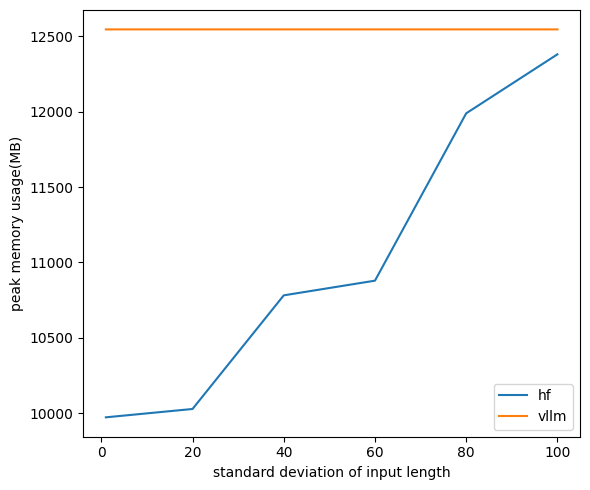

In [ ]:
import torch
import vllm
from vllm import SamplingParams
model_id = "meta-llama/Llama-3.2-1B-Instruct"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import numpy as np
import random

def generate_batch_with_gaussian_lengths(std, mean=200, batch_size=64, vocab="word"):
    """
    Generate a batch of prompts with lengths drawn from a Gaussian distribution.

    Args:
        mean (int): Mean length of the prompts.
        variance (float): Variance of the prompt lengths.
        batch_size (int): Number of prompts in the batch.
        vocab (str): Base word used to construct the prompts.

    Returns:
        List[str]: A list of prompt strings with varying lengths.
    """
    lengths = np.random.normal(loc=mean, scale=std, size=batch_size)
    lengths = np.clip(lengths.astype(int), a_min=1, a_max=None)  # avoid length < 1

    prompts = [" ".join([vocab] * l) for l in lengths]
    return prompts


In [ ]:
# your code begins

# your code ends

**Briefly explain the above result here (5pt):**


```

```






# Step 3: Further improve using speculative decoding(10pt)

As your team prepares to scale up LLM serving in production using vllm, you're exploring advanced techniques to improve generation speed without compromising output quality. One promising technique is [speculative decoding](https://x.com/karpathy/status/1697318534555336961)—a method that leverages a smaller, faster draft model to accelerate decoding for a larger model.

You're now tasked with benchmarking speculative decoding using vLLM, which supports this feature as described in their [doc](
https://docs.vllm.ai/en/latest/features/spec_decode.html).

**Your Task:**

Use the query below and compare the performance of speculative decoding against standard decoding:

Query: "What is speculative decoding? Explain with example and details."

Target model: facebook/opt-1.3b

Speculative model: facebook/opt-125m

**Requirement:**
1. Measure the generation speed (e.g., time per token or total latency) with and without speculative decoding. Store the result in `time_pec`, `time_nospec` variables respectively

2. Ensure that both methods produce the exact same output. Store the output of both methods in `output_spec` and `output_nospec` respectively

3. we will run a grading cell below yours. You should observe that speculative decoding is faster than the baseline. If not, try to tune parameters like num_speculative_tokens.

Hint:
If you encounter the error: got an unexpected keyword argument 'speculative_config', try passing speculative decoding parameters directly (e.g., speculative_model=...) instead of wrapping them in a speculative_config dictionary.

The model may generate non-sense. Don't worry about the output quality, we're using super small models as POC, and the focus is only on efficiency.


In [ ]:
query = "what is speculative decoding? Explain with example and details."
max_token
seed = 42
# your code begins

# your code ends


In [ ]:
# Do not edit this cell
# Print results
# Ensure outputs are the same
assert output_spec == output_nospec, "Outputs do not match!"
print("=== Output ===")
print(output_spec)
print("\n=== Timing ===")
print(f"With Speculative Decoding: {time_spec:.4f} seconds")
print(f"Without Speculative Decoding: {time_nospec:.4f} seconds")
assert time_spec < time_nospec